# Bioinformatics Assignment 2

# 1) Implementing Global Aligment Algorithms

## A - Dot matrix with window scoring

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

<br>The function below simply draws the matrix

In [2]:
def drawMatrix(seq1,seq2,matrix):
    dotplot = plt.imshow(matrix)
    #plt.grid()
    plt.tick_params(labelsize=10, labelbottom = False, bottom=False,labeltop=True)
    xt=plt.xticks(np.arange(len(seq2)),seq2)
    yt=plt.yticks(np.arange(len(seq1)),seq1)
    plt.show()

<br> checkAlignment counts the alignments in the sequences passed, returns a boolean indicating if it is greater than or equal to the threshold

In [3]:
def checkAlignment(sub_seq1,sub_seq2, threshold):
    c = 0 # Counts alignments
    for i in range(len(sub_seq1)):
        if sub_seq1[i] == sub_seq2[i]:
            c+=1
    if c >= threshold: # Check if alignments greater than or equal threshold
        return True
    return False

<br> getAlign checks all the diagonals in the matrix by iterating through row 0, and then column 0. It then finds the starting position of the longest diagonal (most number of 1's in the diagonal). After that, its returns the aligned sequences that are along the longes diagonal. This is supposed to be the bonus part of the assignment

In [4]:
def getAlign(matrix,seq1,seq2):
    horiz = len(seq2)
    vert = len(seq1)
    longest_diagonal = 0
    
    
    ## LOOKING FOR LONGEST DIAGONAL
    for j in range(horiz): # Loops over first row
        row= 0
        col = j
        count = 0
        while(row < vert and col < horiz): 
            if(matrix[row][col] == 1): # If the cell is 1 then increase count
                count+=1
            row+=1 # Move diagonally to the left
            col+=1 
        if(count>longest_diagonal): # Stores position and length of longest diagonal
            longest_diagonal = count
            diagonal_start = (0,j)
        
    for i in range(1,vert): # Loops over first column
        row = i
        col = 0
        count = 0
        while(row < vert and col < horiz):
            if(matrix[row][col] == 1):
                count+=1
            row+=1
            col+=1
        if(count>longest_diagonal):
            longest_diagonal = count
            diagonal_start = (i,0)

            
    s1 = ''
    s2 = ''
    
    i = diagonal_start[0]
    j = diagonal_start[1]
    
    ## RETURNING MATCHING SEQUENCES ON DIAGONAL
    while(i < vert and j < horiz):
        s1 += seq1[i]
        s2 += seq2[j]
        i+=1
        j+=1
    return s1,s2
    
    
    

<br>dotPlotMatrix implements the dot matrix method with window scoring.

In [5]:
def dotPlotMatrix(seq1, seq2, window, step, threshold):
    
    matrix = np.zeros((len(seq1), len(seq2))) #Initialize matrix with zeros
    middle = int((window + 1)/2) # Middle of the window (where the point will be set)
    col_iterations = len(seq2) - window + 1 # Number of horizantal iterations 
    row_iterations = len(seq1) - window + 1 # Number of vertical iterations
    
    for i in range(0,row_iterations + 1, step):
        for j in range(0,col_iterations+1,step):
                        
            thresh = checkAlignment(seq1[i:i+window],seq2[j:j+window],threshold) # Check if it passes threshold
            
            if(thresh):
                matrix[i+middle-1][j+middle-1] = 1 ## Put a dot if greater than threshold

    drawMatrix(seq1,seq2,matrix)
    return getAlign(matrix,seq1,seq2)
            #print('=========================')

### Testing the implementation
Matching<br>
#### ACCTTGTCCTCTTTGCCC<br>
with <br>
#### ACGTTGACCTGTAACCTC<br>
 window size 9,step size 3 and threshold of 4

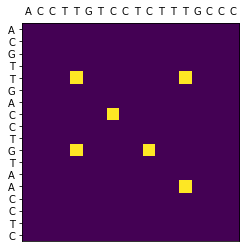

SEQUENCE 1:  ACGTTGACCTGTAACCTC
matches with
SEQUENCE 2:  ACCTTGTCCTCTTTGCCC


In [6]:
seq1 = 'ACGTTGACCTGTAACCTC'
seq2 = 'ACCTTGTCCTCTTTGCCC'

sequences = dotPlotMatrix(seq1,seq2,9,3,4)
print('SEQUENCE 1: ',sequences[0])
print('matches with')
print('SEQUENCE 2: ',sequences[1])

# <n>

## B - Needleman-Wunch Algorithm

<n>initializeMatrices creates the score matrix as well as the direction matrix which will be used in traceback. It fells the first row and column with the cumulative gap cost

In [7]:
def initializeMatrices(seq1,seq2,gap):
    matrix = np.zeros((len(seq1)+1, len(seq2)+1)) # Matrix that stores scores
    
    # Filling first row and first columns with the cumulative gap cost
    x = len(seq2)
    y = len(seq1)
    matrix[0,:] = np.linspace(0,x*gap,x+1)
    matrix[:,0] = np.linspace(0,y*gap,y+1)
    
    tabl = np.empty((y+1,x+1), dtype = object) # Stores solutions (dp tabulation)
    
    # Filling direction matrix first row with 2 (left), and first column with 1 (up)
    tabl[0,:].fill(2)
    tabl[:,0].fill(1)
    ##2 == left, ##1 == up, ##0== diagonal
    return matrix,tabl

<br>printMatrixNw prints the the score matrix and the direction matrix as one table

In [8]:
def printMatrixNw(matrix, tabl,x,y):
    
    direc_dict = {0: 'diag', 1: 'up', 2: 'left' }
    
    tabl_string = np.vectorize(direc_dict.get)(tabl)
    a = np.array([item for item in zip(matrix.flat, tabl_string.flat)],dtype = np.dtype('object,object'))
    new = a.reshape(tabl_string.shape)
    
    tab = plt.table(new, cellLoc= 'center', rowLabels= list(y), colLabels =  list(x), loc = 'top')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    tab.scale(4, 4)
    plt.show()
    

<br>needlemanWunsch function implements the Needleman-Wunsch algorithm which is used to align nucleotide and protein sequences globally. It makes use of dynamic programming by tabulating the sub-solutions after each step. First, it fills the matrix by calculating the maximum score at each cell by taking the match, mismatch, and gap penalties into account. It then stores where  the cell obtained its score from in the directions matrix (whether its from the cell to the left or above or diagonal.) The directions matrix is then used to traceback and print the aligned sequences.

In [9]:
def needlemanWunsch(seq1,seq2,match,mismatch,gap):
    matrix, tabl = initializeMatrices(seq1,seq2,gap)
    
    # Creating labels for the sake of printing each step
    labelx = np.array(list('j' + seq2))
    labely = np.vstack(np.array(list('i' + seq1)))
    
    for i in range(1,len(seq1)+1):         # The nested loops fill the matrix and tabl matrices
        for j in range(1,len(seq2)+1):
            scores = [0,0,0]               # Index 0 == MOVING DIAGONALLY, Index 1 == MOVING UP, Index 2 == MOVING LEFT
            if(seq1[i-1] == seq2[j-1]):
                scores[0] = matrix[i-1][j-1] + match # Score in case of match
                flag = True
            else:
                scores[0] = matrix[i-1][j-1] + mismatch #Score in case of mismatch
                flag = False
                
            scores[1] = matrix[i-1,j] + gap # Score in hgap
            scores[2] = matrix[i,j-1] + gap # Score in vgap
            
            matrix[i][j] = max(scores) # Maximum of all scores is stored 
            tabl[i][j]=scores.index(max(scores)) # Direction is stored in the tabulation array
            
    printMatrixNw(matrix, tabl,labelx,labely)
            
    al1 = '' # Aligned sequece in first dna
    al2 = '' # Aligned sequence in second dna
    i = len(seq1) 
    j = len(seq2)
    # Trackback
    while(i>0 or j >0):
        if tabl[i][j] == 0: # If direc is diagonal, then match/mismatch
            al1+= seq1[i-1]
            al2+= seq2[j-1]
            i-=1
            j-=1
        elif tabl[i][j] == 1: # If direc up then horizantal gap
            al1+= seq1[i-1]
            al2+= '-'
            i-=1
        elif tabl[i][j] == 2: # If direc left then vertical gap
            al1+= '-'
            al2+=seq2[j-1]
            j-=1
    return (al1[::-1]),(al2[::-1]) # Return the flipped strings


### Testing the implementation
We want to match<br>
#### ACGCTG<br>
with <br>
#### CATGT<br>
match score = 2, mismatch score = -1, gap score = -1

#### Printing the table:

C:\Users\LENOVO\anaconda3\envs\bioinf\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if s != self._text:


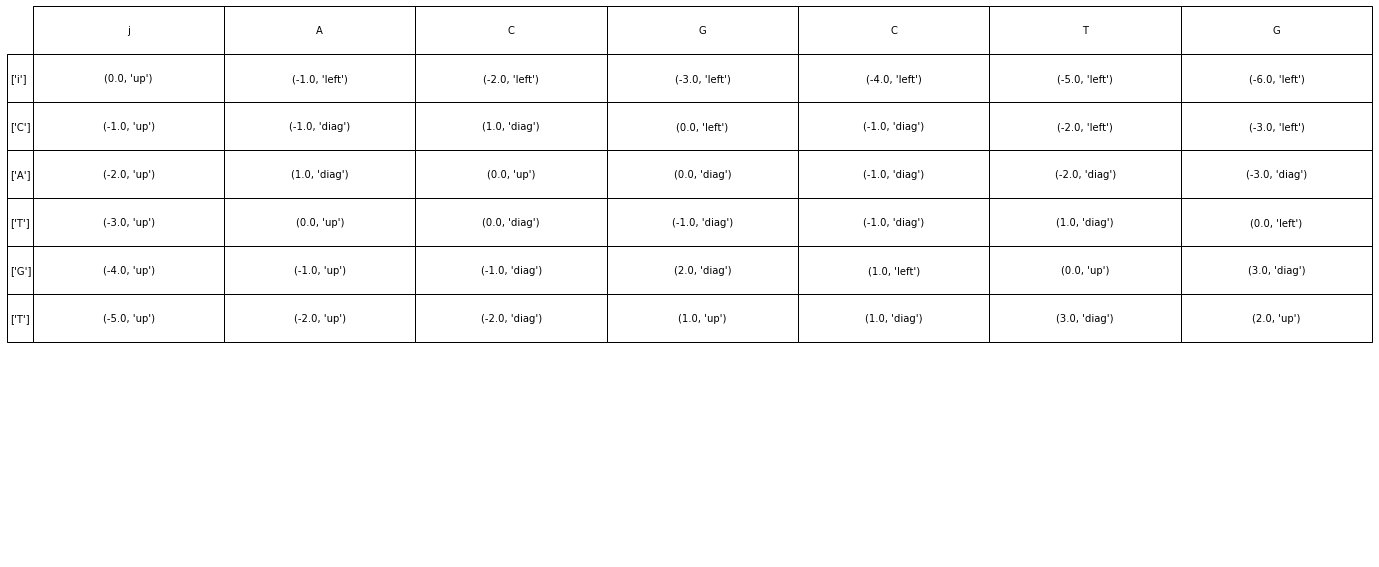

In [10]:
seq1 = 'CATGT'
seq2 = 'ACGCTG'
align = needlemanWunsch(seq1,seq2,2,-1,-1)

#### Printing the aligned sequences after the traceback:

In [11]:
print('ALIGNED SEQUENCES:')
print()
print('SEQUENCE 1: ',align[0])
print('SEQUENCE 2: ',align[1])

ALIGNED SEQUENCES:

SEQUENCE 1:  -C-ATGT
SEQUENCE 2:  ACGCTG-


#                      

# 2 - Implementing Smith-Waterman Algorithm

<br>initializeMatrix simply creates an empty matrix with the size of the sequences. It fills the first row and first column with zeroes

In [12]:
def initializeMatrix(seq1,seq2):
    matrix = np.empty((len(seq1)+1,len(seq2)+1),dtype = 'int64')
    matrix[:,0] = 0
    matrix[0,:] = 0
    return matrix

<br>printMatrixSw prints the matrix as a table

In [13]:
def printMatrixSw(matrix,x,y):
    tab = plt.table(matrix, cellLoc= 'center', rowLabels= list(y), colLabels =  list(x), loc = 'top')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    tab.scale(4, 4)
    plt.show()

<br>smithWaterman implements the Smith-Waterman local alignment algorithm. It is implemented in a similar manner to the Smith-Needleman Algorithm. The matrix is first filled with the maximum calculcated score, however if the maximum score is negative, the value of the cell is set to zero. After the matrix is filled, the algorithm then finds the cell with the maximum value, and traces back through the highest scores until it reaches a cell with value 0.

In [14]:
def smithWaterman(seq1,seq2,match,mismatch,gap):
    matrix = initializeMatrix(seq1,seq2)
    
    label_x = np.array(list('0' + seq2))
    label_y = np.vstack(np.array(list('0' + seq1)))
    for i in range(1,len(seq1)+1):    # Filling the matrix
        for j in range(1,len(seq2)+1):
            scores = [0,0,0,0]
            if(seq1[i-1] == seq2[j-1]):
                scores[0] = matrix[i-1][j-1] + match # Score in case of match
                flag = True # Purpose of the flag is for printing (To know if there is a match or a mismatch)
                
            else:
                scores[0] = matrix[i-1][j-1] + mismatch # Score in case of mismatch
                flag = False
                
            scores[1] = matrix[i-1,j] + gap # score in hgap
            scores[2] = matrix[i,j-1] + gap # score in vgap
            matrix[i][j] = max(scores)
            
    printMatrixSw(matrix,label_x,label_y)
    i,j = np.unravel_index(matrix.argmax(),matrix.shape) # i and j contain co-ordinates of maximum value in the matrix    
    

    # Traceback implemented in a similar way to needleman Wunsch algorithm above
    al1,al2 = '',''
    while(not(matrix[i][j] == 0)): # If cell is 0 then stop
        score = []
        score.append(matrix[i-1,j-1])# moving diag index 0 
        score.append(matrix[i-1,j])  # moving up index 1
        score.append(matrix[i,j-1])  # moving left index 2
        
        direc = score.index(max(score))
        
        if direc == 0:
            al1+= seq1[i-1]
            al2+= seq2[j-1]
            i-=1
            j-=1
        elif direc == 1:
            al1+= seq1[i-1]
            al2+= '-'
            i-=1
        elif direc == 2:
            al1+= '-'
            al2+= seq2[j-1]
            j-=1
    return (al1[::-1]),(al2[::-1])


### Testing the implementation
We want to match<br>
#### TGCTCGTA<br>
with <br>
#### TTCATA<br>
match score = 5, mismatch score = -2, gap score = -6

### Printing the filled table

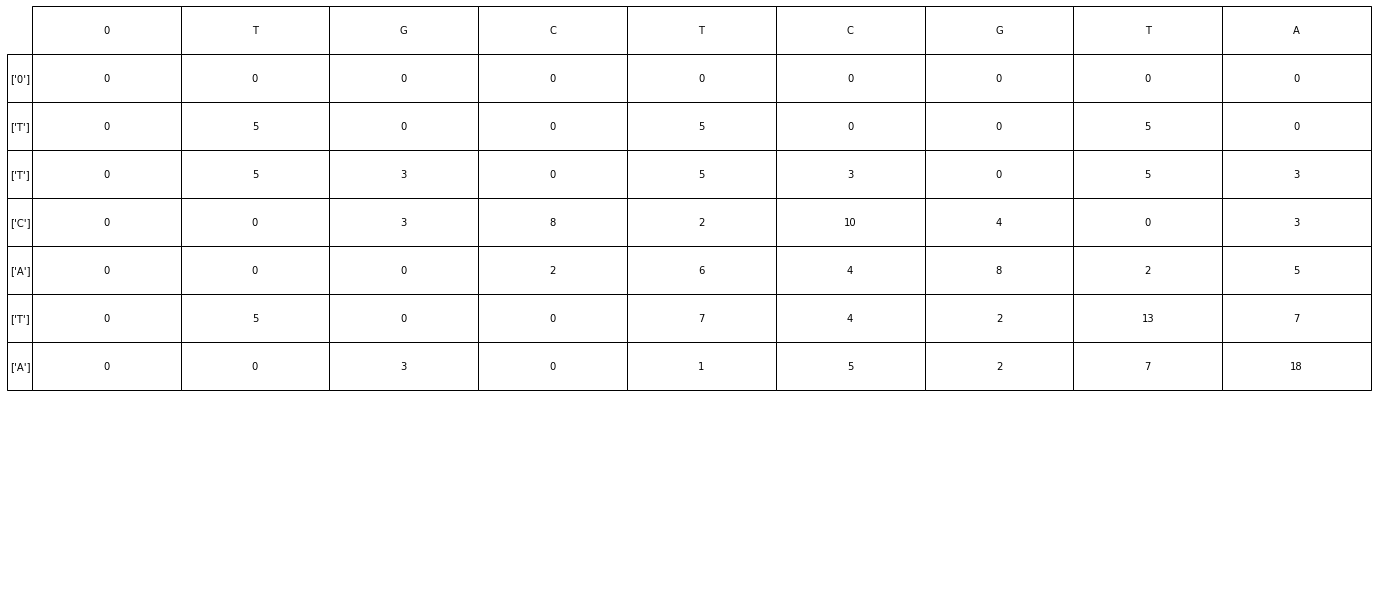

In [15]:
seq1 = 'TTCATA'
seq2 = 'TGCTCGTA'
p = smithWaterman(seq1,seq2,5,-2,-6)

### Printing the aligned sequences

In [16]:
print('ALIGNED SEQUENCES:')
print()
print('SEQUENCE 1: ',p[0])
print('SEQUENCE 2: ',p[1])

ALIGNED SEQUENCES:

SEQUENCE 1:  TTCATA
SEQUENCE 2:  T-CGTA
